# Introduction

## This notebook is to play with the concept of Active Learning and see how to apply it to NLP.

Active Learning is best defined in opposition to its alternative, passive learning. This is the standard method of training a model where you give it a large amount of training data and leave it to learn. Active learning, uses a minimal amount of labelled examples and then asks the model which other datapoints it needs to be labelled for it to be accurate.

<img src = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ42fGMCUXWkEDF4LDfMi5D7GRTBw2efbq9rw&usqp=CAU' alt = 'A robot looking at a laptop to represent it learning'/>

This notebook will:
* Prepare the IMDB reviews database
* Seperate out a training set of examples
* Create a simple NLP model with bidirectional LSTM in Keras (anew for each method)
* Train this on:
    * a 'best case' dataset with 32000 examples in the training data
    * a random sample training set
    * an uncertainty sample training set
    * a diverse sample training set, selected using kmeans clustering
    * a diverse sample training set, selected using k nearest neighbours
    * a combination uncertainty and diversity (k nearest neighbours) sample training set
    * an active transfer learning training set
    * an active transfer learning combined with k nearest neighbours training set
* Each training (except the best case) will involve iterating over:
    * Train the model on the training set
    * Use selection function to select the next examples to add to the training set
    * Retrain the model
* Plot the accuracy and f1 score for each amount of labelled examples for each method chosen

The dataset used is fully labelled so that this example can proceed quickly. However, the model only sees the labels in the training_examples. This is representing a process where you have a lot of unlabelled data and each new labelled example requires a human to annotate. 

In [1]:
# Libraries Used

# Cleaning the data
import pandas as pd
from sklearn.model_selection import train_test_split

# Building the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Diversity Sampling
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors

# The metrics used
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Turn off warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore")

import gc 

In [2]:
!pip install pyarabic

In [3]:

import pandas as pd
df = pd.read_csv(('/kaggle/input/arabic-sentiment/arabic_sentiment.csv'), encoding='utf-8') #orginal dataset


In [4]:
#preprocessing

import re
import nltk
from nltk.corpus import stopwords
from pyarabic.araby import strip_tashkeel
 #text = "الْعَرَبِيّةُ"

# Download stopwords if not already downloaded
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'\d+|\W+', ' ', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    strip_tashkeel(text)
    #حذف الحركات كلها ماعدا الشدة	strip_harakat(text)
    #حذف الحركة الأخيرة	strip_lastharaka(text)
    #حذف التطويل	strip_tatweel(text)
    #تنميط أشكال الهمزة المختلفة	normalize_hamza(text)
    #تفريق كلمات النص	tokenize(text)
    #تفريق جمل النص	sentence_tokenize(text)
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,label
0,النعال المريحة أرتدي النعال كثير فهي دافئة ومر...,1
1,منتج جميل خدمة سيئة لقد اشتريت زوج النعال البا...,1
2,جيد للأشياء الصغيرة يعمل بشكل جيد لالتقاط قطع ...,1
3,واهية للغاية flimsyif للغاية فأنت تشتريه حذر ج...,0
4,Pop for Girls and Girly Boys والأشخاص يحبون ال...,1


# Preprocessing

In [5]:
# The dataset
#df= pd.read_csv('/kaggle/input/imdb-movie-ratings-sentiment-analysis/movie.csv')

# shuffle dataframe to ensure there isn't any data leakage
df = df.sample(frac=1, random_state = 41).reset_index(drop=True)

print('DataFrame information:')
print(df.info())
print()
print('DataFrame value counts')
print(df['label'].value_counts())

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330000 entries, 0 to 329999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    330000 non-null  object
 1   label   330000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ MB
None

DataFrame value counts
1    166853
0    163147
Name: label, dtype: int64


In [6]:
longest = max(df['text'])
print(f"Maximum number of text characters = {len(longest)}")

# This doesn't give the maximum number of words as other entries may have more words but fewer characters
# but is a useful approximation
words = longest.split(' ')
print(f"Number of words in longest entry = {len(words)}")

Maximum number of text characters = 165
Number of words in longest entry = 29


#  Model Functions

In [7]:
# Global variables, MUST ensure all models are trained on same numbers
step_size = 100
number_steps = 20

In [8]:
vectorizer = layers.TextVectorization(
    max_tokens=1000,
   # standardize="lower_and_strip_punctuation",
    output_sequence_length=120)

# the TextVectorization layer needs to be pretrained before putting it into the model
vectorizer.adapt(df['text'])

In [9]:
def get_training_examples(number_needed):
    """
    Randomly select a balanced set of training examples, shuffle and return them as a pd.dataframe
    
    in -> number_needed - number of training examples to return, half will be positive, half negative
    
    out -> pd.dataframe with the inputted number of examples
    """
    # Set up a small labelled set to train the model
    priming_examples = number_needed//2 #So we can get an equal number of positive and negative

    negative_examples = df[df['label']==0].sample(n=priming_examples, random_state = 42)
    positive_examples = df[df['label']==1].sample(n=priming_examples, random_state = 42)

    combined_examples = pd.concat([negative_examples, positive_examples], axis = 0)
    
    # remove training examples from dataframe
    df.drop(combined_examples.index, inplace = True)
    

    # currently we have all 0's then all 1's. This shuffles them.
    combined_examples = combined_examples.sample(frac=1, random_state = 43).reset_index(drop=True)

    return combined_examples

In [10]:
def create_model():
    """
    Create a keras BiLSTM model. Used to ensure each training has an identical but independant model.
    
    in -> None
    out -> Keras BiLSTM model
    
    """
    mdl = keras.models.Sequential(
            [
                layers.Input(dtype=tf.string, shape=(1,)),
                vectorizer,
                layers.Embedding(input_dim=1000, output_dim=128),
                layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
                layers.GlobalMaxPool1D(),
                layers.Dense(20, activation="relu"),
                layers.Dropout(0.5),
                layers.Dense(1, activation="sigmoid"),
            ]
        )
    return mdl

In [11]:
def make_predictions(nn_model, test_series, prediction_split = 0.5):
    """
    Uses the model to find the logits of the test series, 
    then splits this into positive and negative predictions based on inputted split value.
    
    in ->   nn_model - keras BiLSTM model
            test_series - the entries to predict from
            prediction_split - the splitting value, will be 0.5 if not specified. Values that equal split will return 1
            
    out ->  predictions - the logit values
            classifications - either 1 or 0 for positive or negative
    """
    predictions = nn_model.predict(test_series)
    classifications = [0 if x < prediction_split else 1 for x in predictions]
    return predictions, classifications

In [12]:
def get_scores(true_labels, predicted_labels):
    """
    Works out accuracy and F1 score by comparing the true labels to the ones predicted by model.
    Uses functions from SciKit Learn
    
    in ->   true_labels - ground truth labels from dataset
            predicted_labels - labels predicted by model
            
    out ->  accuracy - accuracy score as per scikit learn
            f1 - f1 score as per scikit learn
    """
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    return accuracy, f1

In [13]:
def plot_graphs(history, string):
    """
    graphing function to show bestcase model
    
    in ->  history - records of results from model for each epoch
           string - label to use on graph
    """
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(['Training Set', 'Validation Set'])
    plt.show()

# Training Function

This will ensure that the training is done identically, except for the method used to get the next set of examples, which is passed to the train_model function.

In [14]:
def train_model(get_examples_function, dataframe):
    """
    Get Examples function so return a number of new training examples 
    for the model to train on in a pd.dataframe format.
    
    in ->   get_examples_function - Active Learning function to use
            dataframe - Dataframe to use (each AL function should have its own copy of the dataframe to avoid leakage)
            
    out ->  accuracy_results - list of accuracy results from each training epoch
            f1_results - list of f1 results from each training epoch
    """
    examples = training_examples.copy()
    
    model = create_model()
    
  
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[keras.metrics.BinaryAccuracy()],
    )
    
    current_number_labelled = len(examples)

    accuracy_results = []
    f1_results = []

    for x in range(0, number_steps):

        model.fit(
            examples['text'],
            examples['label'],
            epochs=5,
            verbose=0,
        )

        logits, classifications = make_predictions(model, dataframe['text'])

        result = (get_scores(dataframe['label'], classifications))
        accuracy_results.append(result[0])
        f1_results.append(result[1])
        
        print(f'Current number of labelled examples = {current_number_labelled}')
        print(f'Current Accuracy = {result[0]:.3f}, Current F1 score = {result[1]:.3f}')
        print()        
        
        # Don't create new examples on last time round as they won't be predicted
        if x < number_steps-1:
            #TODO - this code should be refactored, maybe into a class?
            if get_examples_function == random_method:
                new_examples = get_examples_function()
            elif get_examples_function == uncertainty_method:
                new_examples = get_examples_function(logits)
            elif get_examples_function == clusters_method or get_examples_function == neighbours_method:
                extractor = keras.Model(inputs=model.inputs,
                                        outputs=[layer.output for layer in model.layers if layer._name.startswith('embedding')])
                vectors = extractor(dataframe['text'])
                training_vectors = extractor(examples['text'])
                new_examples = get_examples_function(training_vectors, vectors)
            elif get_examples_function == combi_method:
                extractor = keras.Model(inputs=model.inputs,
                                        outputs=[layer.output for layer in model.layers if layer._name.startswith('embedding')])
                vectors = extractor(dataframe['text'])
                training_vectors = extractor(examples['text'])
                new_examples = get_examples_function(logits, training_vectors, vectors)
            elif get_examples_function == transfer_method:
                new_examples = get_examples_function(model)
            elif get_examples_function == transfer_combi_method:
                extractor = keras.Model(inputs=model.inputs,
                                        outputs=[layer.output for layer in model.layers if layer._name.startswith('embedding')])
                vectors = extractor(dataframe['text'])
                training_vectors = extractor(examples['text'])
                new_examples = get_examples_function(model, training_vectors, vectors)
            else: raise ValueError('Dont recognise this function')
            
            examples = pd.concat([new_examples, examples], axis = 0)

            current_number_labelled = len(examples)
    
      
    ConfusionMatrixDisplay.from_predictions(dataframe['label'], classifications, values_format = 'd')
    plt.show()
        
    return accuracy_results, f1_results

# Classifications

We are going to:
* Make classifications using the model
* Show them in a confusion matrix
* Find 100 more examples from our dataset using the chosen method
* Add them (with labels) to the training set
* Retrain the model

and repeat. 

To ensure consistency between the models we will declare the maximum number of training examples and the step size here. If the models are given different amounts of each then it will be difficult to compare them.

In [15]:
training_examples = get_training_examples(step_size)

training_examples.head(10)

,text,label
0,تضيع أموالك غضون أشهر تمديد الأسلحة وعصا الفشل...,0
1,واحدة أضعف المسرحيات الموسيقية MGM المدينة ملح...,0
2,مناشف غسيل أمر التوسع لكنك حصلت دفعته مقابل ال...,0
3,أحصل عليها حسن لقد فازت بالتأكيد بجائزة ووفق ل...,0
4,التعويض المزدوج السيد بروكس فيلم مبهج متبل الف...,1
5,Treasure Island للأولاد الصغار ذهبت الكلاسيكية...,1
6,المظلة تناول الطعام بالخارج دائم قلق بشأن حفيد...,1
7,فرحان ينحرف الفيلم أطرف فيلم رأيته فترة طويلة ...,1
8,بالنسبة الفكري أريد يكونوا أحب يركز الأشخاص يد...,0
9,أفضل بحيرة Swan السوق أفضل بحيرة Swan السوق ال...,1


# Bestcase Model

Lets start by training a model on a massive dataset to see how good it could be

In [16]:
X_train, X_val_test, y_train, y_val_test = train_test_split(df['text'], df['label'], 
                                                            test_size=0.2, random_state=42, 
                                                            stratify = df['label'])

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,
                                                test_size=0.5, random_state=42,
                                                stratify = y_val_test) 

print('Training examples:', X_train.shape, y_train.shape)
print('Validation examples:', X_val.shape, y_val.shape)
print('Test examples:', X_test.shape, y_test.shape)

Training examples: (263920,) (263920,)
Validation examples: (32990,) (32990,)
Test examples: (32990,) (32990,)


In [17]:
bestcase_model = create_model()
    
bestcase_model.summary()

bestcase_model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[keras.metrics.BinaryAccuracy()],
    )

print()
print('Training...')

history = bestcase_model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs=5,
                verbose=2,
            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 120)               0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 128)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 64)           41216     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

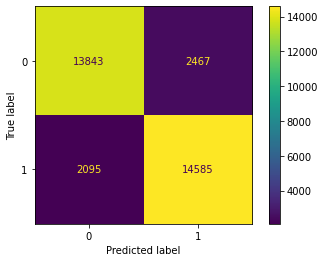

In [18]:
predictions, classifications = make_predictions(bestcase_model, X_test)

ConfusionMatrixDisplay.from_predictions(y_test, classifications, values_format = 'd')
plt.show()

In [19]:
accuracy, f1 = get_scores(y_test, classifications)

print(f"Accuracy = {accuracy:.3f}")
print(f"F1 score = {f1:.3f}")

Accuracy = 0.862
F1 score = 0.865


Binary Accuracy by Epoch


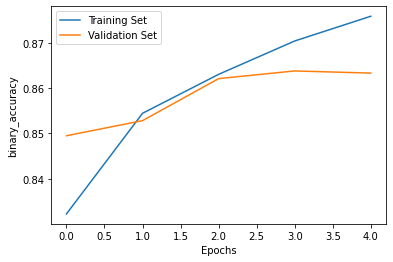


Loss by Epoch


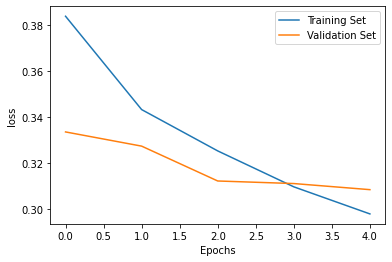

In [20]:
print('Binary Accuracy by Epoch')
plot_graphs(history, "binary_accuracy")
print()
print('Loss by Epoch')
plot_graphs(history, "loss")

# Control Group with Random Sampling

In [21]:
def random_method():
    """
    Control group for comparison. Just selects examples at random from the dataset.
    Removes chosen examples from dataset and returns them as a new pd.dataframe
    
    out ->  new_examples - dataframe with new labelled training examples
    """
    new_examples = random_df.sample(n=step_size)
    
    # remove training examples from dataframe
    random_df.drop(new_examples.index, inplace = True)
    
    new_examples.reset_index(drop=True)
    new_examples = new_examples[['text', 'label']]
    
    return new_examples

Current number of labelled examples = 100
Current Accuracy = 0.495, Current F1 score = 0.001

Current number of labelled examples = 200
Current Accuracy = 0.621, Current F1 score = 0.485

Current number of labelled examples = 300
Current Accuracy = 0.692, Current F1 score = 0.678

Current number of labelled examples = 400
Current Accuracy = 0.699, Current F1 score = 0.716

Current number of labelled examples = 600
Current Accuracy = 0.691, Current F1 score = 0.726

Current number of labelled examples = 700
Current Accuracy = 0.712, Current F1 score = 0.711

Current number of labelled examples = 800
Current Accuracy = 0.707, Current F1 score = 0.700

Current number of labelled examples = 900
Current Accuracy = 0.717, Current F1 score = 0.722

Current number of labelled examples = 1000
Current Accuracy = 0.715, Current F1 score = 0.715

Current number of labelled examples = 1100
Current Accuracy = 0.715, Current F1 score = 0.713

Current number of labelled examples = 1200
Current Accurac

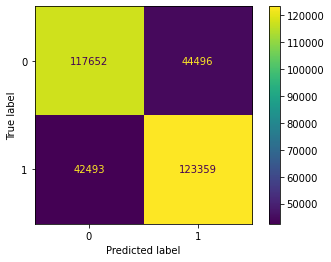

67551

In [22]:
# Don't want the methods to have an effect on each others dataframes
random_df = df.copy()
random_accuracy, random_f1 = train_model(random_method, random_df)

# To reduce memory usage
del random_df
random_df = ''
gc.collect()

# Active Learning using Uncertainty

For this method we will look at the uncertainty of the predictions by finding those that are closest to the decision boundary (0.5) and adding those to our training examples

In [23]:
def uncertainty_method(predictions):       
    """
    AL function that chooses new examples by finding those closest to the midrange point between predictions
    
    in ->  predictions - the logits returned by the model
    
    out ->  new_examples - dataframe with new labelled training examples
    """
    uncertainty_df['predictions'] = predictions

    uncertainty_label = 'Uncertainty'

    uncertainty_df['Uncertainty'] = abs(uncertainty_df['predictions'] - 0.5)

    new_examples = uncertainty_df.nsmallest(step_size, columns = uncertainty_label, keep='all')
    
    # remove training examples from dataframe
    uncertainty_df.drop(new_examples.index, inplace = True)
    
    new_examples = new_examples[['text', 'label']]
    
    return new_examples

In [ ]:
# Don't want the methods to have an effect on each others dataframes
uncertainty_df = df.copy()
uncertainty_accuracy, uncertainty_f1 = train_model(uncertainty_method, uncertainty_df)

# To reduce memory usage
del uncertainty_df
uncertainty_df = ''
gc.collect()

Current number of labelled examples = 200
Current Accuracy = 0.506, Current F1 score = 0.672

Current number of labelled examples = 300
Current Accuracy = 0.668, Current F1 score = 0.617

Current number of labelled examples = 400
Current Accuracy = 0.695, Current F1 score = 0.703

Current number of labelled examples = 500
Current Accuracy = 0.717, Current F1 score = 0.725

Current number of labelled examples = 600
Current Accuracy = 0.717, Current F1 score = 0.701

Current number of labelled examples = 700
Current Accuracy = 0.725, Current F1 score = 0.718

Current number of labelled examples = 800
Current Accuracy = 0.737, Current F1 score = 0.729

Current number of labelled examples = 900
Current Accuracy = 0.750, Current F1 score = 0.747

Current number of labelled examples = 1000
Current Accuracy = 0.754, Current F1 score = 0.759

Current number of labelled examples = 1100
Current Accuracy = 0.759, Current F1 score = 0.758

Current number of labelled examples = 1200
Current Accurac

# Active Learning with Diversity Sampling of Clusters

In [ ]:
def transfer_combi_method(model, training_vectors, vectors):
    """
    2 stage combination model.
    
    First Stage:
    Takes main model, removes last layer and freezes the rest. Then adds 3 new layers to learn where the old model is weak.
    Passes 10x [step_size] examples to next stage
    
    Second Stage:
    Uses K nearest neighbours to find the most diverse examples from this list and return them    
    
    in ->   nn_model - main model used to predict sentiment
    out ->  new_examples - dataframe with new labelled training examples
    """
    
    _, transfer_combi_validation['classifications'] = make_predictions(model, transfer_combi_validation['text'])
    
    transfer_combi_validation['correct'] = (transfer_combi_validation['classifications'] == transfer_combi_validation['label']).astype(int)
    
    al_model= keras.models.clone_model(model)
    al_model.set_weights(model.get_weights())
    
    al_model.pop()
    for layer in al_model.layers:
        layer.trainable = False
    al_model.add(layers.Dense(20, activation="relu"))
    al_model.add(layers.Dense(20, activation="relu"))
    al_model.add(layers.Dense(1, activation="sigmoid"))
    
    #al_model.summary()
    
    al_model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[keras.metrics.BinaryAccuracy()],
    )
                 
    al_model.fit(
        transfer_combi_validation['text'], transfer_combi_validation['correct'],
        epochs=10,
        verbose=0,
    )
                 
    transfer_combi_df['logits'] = al_model.predict(transfer_combi_df['text'])
    
    transfer_combi_df['vectors'] = [x for x in vectors]
                 
    new_examples = transfer_combi_df.nsmallest(step_size*10, columns = 'logits', keep='all')
    
    vectorized_training = []
    vectorized_reviews = []
    
    for item in training_vectors:
        vectors = np.asarray(item)
        avg_vec = vectors.mean(axis=0)
        vectorized_training.append(avg_vec)
    
    for item in new_examples['vectors']:
        vectors = np.asarray(item)
        avg_vec = vectors.mean(axis=0)
        vectorized_reviews.append(avg_vec)
        
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(vectorized_training)
    distances, indices = nbrs.kneighbors(vectorized_reviews)
    new_examples['distances'] = distances[:, 1]
    
    new_examples = new_examples.nlargest(step_size, columns = 'distances', keep='all')
    
    transfer_combi_df.drop(new_examples.index, inplace = True)
    
    new_examples = new_examples[['text', 'label']]
    
    return new_examples 


In [ ]:

# Don't want the methods to have an effect on each others dataframes
transfer_combi_df = df.copy()

# This method will require an extra validation set
transfer_combi_validation = get_training_examples(step_size*4)

transfer_combi_accuracy, transfer_combi_f1 = train_model(transfer_combi_method, transfer_combi_df)

# To reduce memory usage
del [transfer_combi_df, transfer_combi_validation]
transfer_combi_df = ''
transfer_combi_validation = ''
gc.collect()

# Metrics

In [ ]:
# Seperate out our results into individual dataframes

def show_graphs(lists, column_names_lst):
    """
    Show results from models. Assumes that models are all using the same amounts of learning examples
    
    in ->   lists - nested lists of results from the different models
            column_names_lst - list of names for the results to be used as the legend
    """
    # Need to account for the initial training set (this is equal to the index steps)
    index_ = list(range(step_size, (number_steps*step_size)+step_size, step_size))
    
    try:
        for scores_lst in lists:
            if len(scores_lst) != len(index_):
                raise ValueError('Scores do not match each other')
        
        temp_lst = list(zip(*lists))

        graph_df = pd.DataFrame(data = temp_lst, index = index_, columns = column_names_lst)    


        # Plot the accuracy
        graph_df.plot()
        plt.show()
        
    except Exception as e:
        print(e)

In [ ]:
bestcase_accuracy = [accuracy] * len(random_accuracy)
bestcase_f1 = [f1] * len(random_f1)

accuracy_lists = [bestcase_accuracy, random_accuracy, uncertainty_accuracy]
f1_lists = [bestcase_f1, random_f1, uncertainty_f1]

column_names_lst = ['BestCase Model', 'Random', 'Uncertainty']

print('Accuracy by Number of labelled Examples')

show_graphs(accuracy_lists, column_names_lst)

In [ ]:
print('F1 score by Number of labelled Examples')

show_graphs(f1_lists, column_names_lst)

In [ ]:
print('Final Accuracy Scores')

rankings = pd.DataFrame({'Method': column_names_lst, 'Final Accuracy':[x[-1] for x in accuracy_lists]})

rankings.sort_values('Final Accuracy', ascending = False, inplace = True)

rankings.reset_index(inplace = True, drop = True)

    
rankings.head(10)

# Conclusion

In this notebook, we have implimented a bestcase model, random sampling, uncertainty sampling, diversity sampling (2 different types), a combination model (uncertainty and diversity), active transfer learning and combination active transfer and diversity. Of these the top scoring method varies with each run but it is clear that uncertainty and active transfer learning consistently score about 3% higher than random sampling. Combining these with diversity sample does not produce a large difference but there are some signs that combining transfer learning with diverse sampling does score more highly while combining uncertainty sampling with diversity does not. The margins on this are very small though so could be down to chance. 

Implimenting diversity sampling in isolation does not work well and is consistently out performed by random sampling. Therefore this method should only be used in combination with others.

It was surprising that the combination methods did not significantly outperform the singular methods. This could be due to the data being relatively uniform as this would negate the need for diversity or it could be that combining with diversity sampling is not the best way to teach the model the other parts of the problem. Future notebooks will cover multi-category problems so this should become clearer. 

Future notebooks will also consider other NLP architectures particually BERT and DistilBERT. It will be interesting to see how these methods need to be adapted to fit these models.